In [1]:
# Spark imports
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
import pyspark.sql.functions as F 
from pyspark.storagelevel import StorageLevel

# Python imports
import os
import time
from datetime import datetime, date, tzinfo, timezone

In [29]:
sc.stop()

In [2]:
UID           = "kkan"      # Your Argonet ID.
hadoop_master = "192.168.1.250"  # IP address to Spark Master, which, for our cluster, is the same as the Hadoop Name node address.  

In [ ]:
# 1) Install Python wrappers (works in Jupyter)
# If you already have it, this is a no-op.
# %pip install -q synapseml==1.0.13 scikit-learn matplotlib seaborn

# 2) Start (or restart) your Spark session with the SynapseML JAR attached
# from pyspark.sql import SparkSession

''' This config uses more executors with relatively fewer cores and memory than configs below. '''
# # Create spark session with variables below.  Please try to remember to add your argonet ID to the appName, so that we know who a running job belongs to.
# spark = SparkSession.builder.appName("SynapseML Isolation Forest ZeekData22 - " + UID)                        \
#                             .master("spark://" + hadoop_master + ":7077")                      \
#                             .config("SPARK_LOCAL_IP", hadoop_master)                           \
#                             .config("spark.driver.cores", "5")                                 \
#                             .config("spark.driver.memory", "40g")                              \
#                             .config("spark.executor.memory", "40g")                             \
#                             .config("spark.executor.cores", "5")                               \
#                             .config("spark.dynamicAllocation.shuffleTracking.enabled", "true") \
#                             .config("spark.dynamicAllocation.enabled", "true")                 \
#                             .config("spark.dynamicAllocation.minExecutors", "5")               \
#                             .config("spark.dynamicAllocation.maxExecutors", "10")               \
#                             .config("spark.executor.instances", "5")                           \
#                             .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.8")      \
#                             .getOrCreate()

''' This config uses roughly the same cores and memory as the one above, but with those cores and memory allocated 
    to fewer executors. I found that this config roughly halved the run time of the config above.  
'''
# # Create spark session with variables below.  Please try to remember to add your argonet ID to the appName, so that we know who a running job belongs to.
# spark = SparkSession.builder.appName("SynapseML Isolation Forest ZeekData22 - " + UID)                        \
#                             .master("spark://" + hadoop_master + ":7077")                      \
#                             .config("SPARK_LOCAL_IP", hadoop_master)                           \
#                             .config("spark.driver.cores", "8")                                 \
#                             .config("spark.driver.memory", "60g")                              \
#                             .config("spark.executor.memory", "64g")                             \
#                             .config("spark.executor.cores", "10")                               \
#                             .config("spark.dynamicAllocation.shuffleTracking.enabled", "true") \
#                             .config("spark.dynamicAllocation.enabled", "true")                 \
#                             .config("spark.dynamicAllocation.minExecutors", "3")               \
#                             .config("spark.dynamicAllocation.maxExecutors", "5")               \
#                             .config("spark.executor.instances", "3")                           \
#                             .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.8")      \
#                             .getOrCreate()


''' This config uses the same memory/core allocation per executor as the one just above, but increases the executor 
    count.  I found that this did decrease run time a bit, but I had also added a couple of missing columns to the 
    training dataset, so an accurate comparison is difficult. 
'''
# Create spark session with variables below.  Please try to remember to add your argonet ID to the appName, so that we know who a running job belongs to.
spark = SparkSession.builder.appName("SynapseML Isolation Forest ZeekData22 - " + UID)                        \
                            .master("spark://" + hadoop_master + ":7077")                      \
                            .config("SPARK_LOCAL_IP", hadoop_master)                           \
                            .config("spark.driver.cores", "8")                                 \
                            .config("spark.driver.memory", "60g")                              \
                            .config("spark.executor.memory", "64g")                             \
                            .config("spark.executor.cores", "10")                               \
                            .config("spark.dynamicAllocation.shuffleTracking.enabled", "true") \
                            .config("spark.dynamicAllocation.enabled", "true")                 \
                            .config("spark.dynamicAllocation.minExecutors", "5")               \
                            .config("spark.dynamicAllocation.maxExecutors", "8")               \
                            .config("spark.executor.instances", "5")                           \
                            .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.8")      \
                            .getOrCreate()


# I've observed some strange behaviors with Spark and Python regarding timestamps and timezones.  All of our timestamps are supposed to be in the UTC
# timezone, across all data sources, so I setup my Spark config and Python timezones to UTC globally.  I've not put the Spark timezone setting in the
# Spark session builder so that it's easier to comment out if needed.  Also, you can copy the Spark session builder above without the, typically
# uncessary, config option setting the spark timezone to UTC.   
spark.conf.set("spark.sql.session.timeZone", "UTC")
spark.conf.set("spark.sql.debug.maxToStringFields", 2000)
os.environ['TZ'] = 'UTC'  # This sets the Python timezone to UTC globally to match the Pyspark setting.
time.tzset()

sc = spark.sparkContext  # Get the current Spark session's Spark context, and assign to variable 'sc'.  You'll see this in a lot of examples. 
sc._conf.getAll()        # This prints the configuration options from the Spark context.  This helps debug problems.  Compare to settings in Spark Session Builder.

try:
    from synapse.ml.isolationforest import IsolationForest
    print("✅ SynapseML IsolationForest import works!")
except Exception as e:
    print("❌ Import failed:", e)

print(sc._jvm.com.microsoft.azure.synapse.ml)
print(sc._jvm.scala.util.Properties.versionString())

print("Spark:", spark.version)


25/11/14 15:15:53 WARN Utils: Your hostname, car-ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.1.145 instead (on interface ens33)
25/11/14 15:15:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/ubuntu/pyspark-venv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-13c892bf-926b-4823-acd4-7e7441a9422c;1.0
	confs: [default]
	found com.microsoft.azure#synapseml_2.12;1.0.8 in central
	found com.microsoft.azure#synapseml-core_2.12;1.0.8 in central
	found org.apache.spark#spark-avro_2.12;3.4.1 in central
	found org.tukaani#xz;1.9 in central
	found commons-lang#commons-lang;2.6 in central
	found org.scalactic#scalactic_2.12;3.2.14 in central
	found org.scala-lang#scala-reflect;2.12.15 in central
	found io.spray#spray-json_2.12;1.3.5 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents.client5#httpclient5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5-h2;5.1.3 in central
	found org.slf4j#slf4j-api;1.7.25 in 

✅ SynapseML IsolationForest import works!
version 2.12.18
Spark: 3.5.5


### <span style='color:#0070ff'>Isolation Forest on Network Traffic (PySpark + SynapseML)</span>

In [4]:
import os, time
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from synapse.ml.isolationforest import IsolationForest
from sklearn.metrics import precision_recall_curve, roc_auc_score
from pyspark.sql import SparkSession, functions as F
import shap
from sklearn.ensemble import IsolationForest as SklearnIF
from pyspark.ml.feature import RegexTokenizer, CountVectorizer

# --------------------------
# CONFIG
# --------------------------
RANDOM_STATE = 42          # reproducibility
DEFAULT_CONTAM = 0.05      # fallback contamination rate
TOPK_ONEHOT = 50           # for categorical remap

/home/ubuntu/pyspark-venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### <span style='color:Red'>The Following Cells Read Data From HDFS, But Are Not Required To Run</span>
* RP:  We went over reading the data from HDFS in our meeting, but I wanted to keep these here for reference.  I copied the read operation for the full dataset's parquet files into the cell "1. Load Dataset (Parquet)"

In [7]:
# # Spark read a single parquet file from UWF-ZeekData22 and compare to the method below that reads all parquets
parquet_single_path = "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-09 - 2022-01-16/part-00000-36240b61-b84f-4164-a873-d7973e652780-c000.snappy.parquet"
df_single = spark.read.parquet(parquet_single_path)
print("Record count for single parquet file:  " + "{:,}".format(df_single.count()))
df_single.select("ts", "uid", "src_ip_zeek", "dest_ip_zeek", "src_port_zeek", "dest_port_zeek", "label_tactic").show()

Record count for single parquet file:  2,579,855
+-------------------+------------------+-------------+------------+-------------+--------------+------------+
|                 ts|               uid|  src_ip_zeek|dest_ip_zeek|src_port_zeek|dest_port_zeek|label_tactic|
+-------------------+------------------+-------------+------------+-------------+--------------+------------+
|1.641916792612548E9|CBsIgl2bkWyZoM7nhi|143.88.255.10|   10.0.10.1|        36724|            53|        none|
|1.641916792613393E9|Cfvg1s30ewE42BK8na|143.88.255.10|   10.0.10.1|        37345|            53|        none|
|1.641916792613472E9|CeDHBp2CjuXOrahHB7|143.88.255.10|   10.0.10.1|        49713|            53|        none|
|1.641916792613885E9|CDtdQo2pFBWoM2zp1l|143.88.255.10|   10.0.10.1|        48285|            53|        none|
| 1.64191679261421E9| CMo3hn81DOI1WYvE3|143.88.255.10|   10.0.10.1|        57585|            53|        none|
|1.641916792614292E9|CXqgzC2NDfhAAgwe08|143.88.255.10|   10.0.10.1|    

In [7]:
# # Read full dataset parquet files for ZeekData22 dataset.
parquets_path = "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/*/part-*.parquet"
df = spark.read.parquet(parquets_path)
print("Record count for all parquet files:  " + "{:,}".format(df.count()))
df.select("ts", "uid", "src_ip_zeek", "dest_ip_zeek", "src_port_zeek", "dest_port_zeek", "label_tactic").show(5)

Record count for single parquet file:  18,562,468
+-------------------+------------------+--------------------+---------------+-------------+--------------+------------+
|                 ts|               uid|         src_ip_zeek|   dest_ip_zeek|src_port_zeek|dest_port_zeek|label_tactic|
+-------------------+------------------+--------------------+---------------+-------------+--------------+------------+
|1.639746045896897E9|Caxllt2aEzXOEZnpii|       143.88.255.50|     143.88.0.1|            8|             0|        none|
|1.639746047630312E9|CEx0rX1Yic8axI4sw1|        143.88.255.1|  143.88.255.10|            3|             1|        none|
|1.639746045879347E9|Cpn5bT1QW9MPFXikn4|fe80::250:56ff:fe...|        ff02::1|          134|           133|        none|
|1.639746045888899E9|Ceo6B73UmSZVe8vsD4|fe80::250:56ff:fe...|       ff02::16|          143|             0|        none|
|1.639746070260517E9|CTCPKc2faq2rLYJA4f|             0.0.0.0|255.255.255.255|           68|            67|    

In [10]:
# # Read in the file metrics csv file for ZeekData22.
file_metrics_path = "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/_parquet_file_metrics_/part-00000-d32a9d5e-45b7-4e51-807e-1af297aba2df-c000.csv"
df_file_metrics = spark.read.option("header", True).csv(file_metrics_path)
df_file_metrics.show()

+--------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|        label_tactic|2021-12-12 - 2021-12-19|2021-12-19 - 2021-12-26|2021-12-26 - 2022-01-02|2022-01-02 - 2022-01-09|2022-01-09 - 2022-01-16|2022-01-16 - 2022-01-23|2022-02-06 - 2022-02-13|2022-02-13 - 2022-02-20|
+--------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|   Credential Access|                   NULL|                   NULL|                   NULL|                   NULL|                   NULL|                   NULL|                   NULL|                     31|
|     Defense Evasion|                   NULL|                   NULL|                   NULL|                   NULL|                   NUL

### <span style='color:#0070ff'>1. Load Dataset (Parquet)</span>
* RP:  I copied the read operation for the full dataset from above, so you don't have to run those cells. 

In [6]:
# Read full dataset parquet files for ZeekData22 dataset.
parquets_path = "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/*/part-*.parquet"
df = spark.read.parquet(parquets_path)
print("Record count for all parquet files:  " + "{:,}".format(df.count()))
df.select("ts", "uid", "src_ip_zeek", "dest_ip_zeek", "src_port_zeek", "dest_port_zeek", "label_tactic").show(5)
# print("Rows:", df.count(), "Cols:", len(df.columns))
# df.printSchema()

Record count for all parquet files:  18,562,468
+-------------------+------------------+--------------------+---------------+-------------+--------------+------------+
|                 ts|               uid|         src_ip_zeek|   dest_ip_zeek|src_port_zeek|dest_port_zeek|label_tactic|
+-------------------+------------------+--------------------+---------------+-------------+--------------+------------+
|1.639746045896897E9|Caxllt2aEzXOEZnpii|       143.88.255.50|     143.88.0.1|            8|             0|        none|
|1.639746047630312E9|CEx0rX1Yic8axI4sw1|        143.88.255.1|  143.88.255.10|            3|             1|        none|
|1.639746045879347E9|Cpn5bT1QW9MPFXikn4|fe80::250:56ff:fe...|        ff02::1|          134|           133|        none|
|1.639746045888899E9|Ceo6B73UmSZVe8vsD4|fe80::250:56ff:fe...|       ff02::16|          143|             0|        none|
|1.639746070260517E9|CTCPKc2faq2rLYJA4f|             0.0.0.0|255.255.255.255|           68|            67|      

In [6]:
# Print column names
print(df.columns)

['resp_pkts', 'service', 'orig_ip_bytes', 'local_resp', 'missed_bytes', 'proto', 'duration', 'conn_state', 'dest_ip_zeek', 'orig_pkts', 'community_id', 'resp_ip_bytes', 'dest_port_zeek', 'orig_bytes', 'local_orig', 'datetime', 'history', 'resp_bytes', 'uid', 'src_port_zeek', 'ts', 'src_ip_zeek', 'label_tactic']


In [10]:
# Read full dataset parquet files for ZeekData24 dataset.
parquets_path = "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/*/part-*.parquet"
df = spark.read.parquet(parquets_path)
print("Record count for all parquet files:  " + "{:,}".format(df.count()))
df.select("ts", "uid", "src_ip_zeek", "dest_ip_zeek", "src_port_zeek", "dest_port_zeek", "label_tactic").show(5)
# print("Rows:", df.count(), "Cols:", len(df.columns))
# df.printSchema()

Record count for all parquet files:  1,916,757
+-------------------+-----------------+------------+------------+-------------+--------------+--------------------+
|                 ts|              uid| src_ip_zeek|dest_ip_zeek|src_port_zeek|dest_port_zeek|        label_tactic|
+-------------------+-----------------+------------+------------+-------------+--------------+--------------------+
|1.709262833834568E9|CsiaSX1pkBGBkxFSj|143.88.15.10| 143.88.1.19|        41841|           445|     Defense Evasion|
|1.709262833834568E9|CsiaSX1pkBGBkxFSj|143.88.15.10| 143.88.1.19|        41841|           445|      Initial Access|
|1.709262833834568E9|CsiaSX1pkBGBkxFSj|143.88.15.10| 143.88.1.19|        41841|           445|         Persistence|
|1.709262833834568E9|CsiaSX1pkBGBkxFSj|143.88.15.10| 143.88.1.19|        41841|           445|Privilege Escalation|
|1.709390791076336E9|CLqHLYkLdz4jhl6v4|143.88.15.10| 143.88.1.19|        46223|           445|     Defense Evasion|
+-------------------+----

In [13]:
# Read full dataset parquet files for ZeekDataFall22 dataset.
parquets_path = "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekDataFall22/parquet/*/part-*.parquet"
df = spark.read.parquet(parquets_path)
print("Record count for all parquet files:  " + "{:,}".format(df.count()))
df.select("ts", "uid", "src_ip_zeek", "dest_ip_zeek", "src_port_zeek", "dest_port_zeek", "label_tactic").show(5)
# print("Rows:", df.count(), "Cols:", len(df.columns))
# df.printSchema()

Record count for all parquet files:  700,340
+-------------------+------------------+-------------+-------------+-------------+--------------+------------+
|                 ts|               uid|  src_ip_zeek| dest_ip_zeek|src_port_zeek|dest_port_zeek|label_tactic|
+-------------------+------------------+-------------+-------------+-------------+--------------+------------+
|1.640438923881407E9| Csb8DQGeuzCNSXgic|143.88.255.10|    10.0.10.1|        46174|            53|        none|
|1.640439619634755E9|CmoBLA1dJ8zxMB8uhf|143.88.255.10|    10.0.10.1|        40129|            53|        none|
|1.640137549038774E9|CL2cBA1CLarFrwLLje|  143.88.1.51|   143.88.1.1|        34469|            53|        none|
|1.640438681884798E9| CvY84j2I3164PDwpd|143.88.255.10|    10.0.10.1|        44535|            53|        none|
|1.640236708273935E9|CqSJGe2j9BUXWJQ8f5| 143.88.255.1|143.88.255.10|        48565|            53|        none|
+-------------------+------------------+-------------+-------------

In [16]:
# Read full dataset parquet files for ZeekDataFall24-2 dataset.
parquets_path = "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekDataFall24-2/parquet/*/part-*.parquet"
df = spark.read.parquet(parquets_path)
print("Record count for all parquet files:  " + "{:,}".format(df.count()))
df.select("ts", "uid", "src_ip_zeek", "dest_ip_zeek", "src_port_zeek", "dest_port_zeek", "label_tactic").show(5)
# print("Rows:", df.count(), "Cols:", len(df.columns))
# df.printSchema()

Record count for all parquet files:  2,909,841
+-------------------+------------------+------------+------------+-------------+--------------+------------+
|                 ts|               uid| src_ip_zeek|dest_ip_zeek|src_port_zeek|dest_port_zeek|label_tactic|
+-------------------+------------------+------------+------------+-------------+--------------+------------+
|1.727055361218928E9| C00CPAHwoExlBgXY1| 143.88.5.14| 143.88.5.15|        46644|         48627|   Discovery|
|1.727055178389675E9|C00RpG2jRnGHj7twph| 143.88.5.14| 143.88.5.12|        36302|         31984|   Discovery|
|1.727041609447535E9| C00URr1363KC43P0H|143.88.11.11| 143.88.11.1|        50040|         17168|   Discovery|
|1.727055193817149E9|C00aSH3sN8S68Fko0k| 143.88.5.14|  143.88.5.1|        49290|         53963|   Discovery|
|1.727055157117586E9| C00rbis8Ysjqvo5n3| 143.88.5.14| 143.88.5.10|        35020|          7755|   Discovery|
+-------------------+------------------+------------+------------+-------------+-

In [5]:
# Read full dataset parquet files for ZeekDataSum25-1 dataset.
parquets_path = "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekDataSum25-1/parquet/*/part-*.parquet"
df = spark.read.parquet(parquets_path)
print("Record count for all parquet files:  " + "{:,}".format(df.count()))
df.select("ts", "uid", "src_ip_zeek", "dest_ip_zeek", "src_port_zeek", "dest_port_zeek", "label_tactic", "conn_state").show(5)
# print("Rows:", df.count(), "Cols:", len(df.columns))
# df.printSchema()

Record count for all parquet files:  1,154,353
+-------------------+------------------+-----------+-------------+-------------+--------------+------------+----------+
|                 ts|               uid|src_ip_zeek| dest_ip_zeek|src_port_zeek|dest_port_zeek|label_tactic|conn_state|
+-------------------+------------------+-----------+-------------+-------------+--------------+------------+----------+
|1.747978631860769E9| CNtQD6tt6YAy7uvwc|143.88.0.14|143.88.255.10|        43258|            53|        none|        S0|
|1.747976527156256E9|CoQmxI2X7Tu3rJuoNj|143.88.4.11|143.88.255.10|        38609|            53|        none|        S0|
|1.747977005381352E9|CD8ybe4gwwcrU2F2C1|143.88.2.11|143.88.255.10|        35336|            53|        none|        S0|
|  1.7479785512206E9|ChLsUn31xD3utUWC8b|143.88.0.14|143.88.255.10|        28276|            53|        none|        S0|
|1.747976416709337E9|CgPjMm3P1xFLioJu6c| 143.88.0.6|143.88.255.10|        20280|            53|        none|     

25/11/05 13:06:34 ERROR StandaloneSchedulerBackend: Application has been killed. Reason: Master removed our application: KILLED
25/11/05 13:06:34 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exiting due to error from cluster scheduler: Master removed our application: KILLED
	at org.apache.spark.errors.SparkCoreErrors$.clusterSchedulerError(SparkCoreErrors.scala:291)
	at org.apache.spark.scheduler.TaskSchedulerImpl.error(TaskSchedulerImpl.scala:981)
	at org.apache.spark.scheduler.cluster.StandaloneSchedulerBackend.dead(StandaloneSchedulerBackend.scala:165)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint.markDead(StandaloneAppClient.scala:263)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint$$anonfun$receive$1.applyOrElse(StandaloneAppClient.scala:170)
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:115)
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213)
	at org.apache.spark.rpc.netty.Inbox.proce

In [5]:
# Read full dataset parquet files for ZeekDataSum25-2 dataset.
parquets_path = "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekDataSum25-2/parquet/*/part-*.parquet"
df = spark.read.parquet(parquets_path)
print("Record count for all parquet files:  " + "{:,}".format(df.count()))
df.select("ts", "uid", "src_ip_zeek", "dest_ip_zeek", "src_port_zeek", "dest_port_zeek", "label_tactic", "conn_state").show(5)
# print("Rows:", df.count(), "Cols:", len(df.columns))
# df.printSchema()

Record count for all parquet files:  1,868,679
+-------------------+------------------+-----------+-------------+-------------+--------------+------------+----------+
|                 ts|               uid|src_ip_zeek| dest_ip_zeek|src_port_zeek|dest_port_zeek|label_tactic|conn_state|
+-------------------+------------------+-----------+-------------+-------------+--------------+------------+----------+
|1.747990996421036E9| C2jS0g3BhpBr5ZW9R|143.88.2.11|143.88.255.10|        40550|            53|        none|        S0|
| 1.74804295277333E9|Cm6WIs17q6kvMOFg21| 143.88.0.6|143.88.255.10|        56666|            53|        none|        S0|
|1.748118867269501E9| Cujjdb415fCCiiu9h| 143.88.0.6|143.88.255.10|        64752|            53|        none|        S0|
|1.748055549680873E9|  Ckd8MbPJw6cZawx1|143.88.0.10|192.58.128.30|        24529|            53|        none|        S0|
|1.748052320304448E9|C5tLAR1zdyHE6OeUg8|143.88.0.14|143.88.255.10|        64233|            53|        none|     

### <span style='color:#0070ff'>2. Inspect unique values in label_tactic</span>

In [6]:
# Inspect unique values
df.select("label_tactic").distinct().show(truncate=False)

# Count how many rows per tactic
df.groupBy("label_tactic").count().orderBy(F.desc("count")).show(50, truncate=False)

+--------------+
|label_tactic  |
+--------------+
|none          |
|Discovery     |
|Reconnaissance|
+--------------+

+--------------+------+
|label_tactic  |count |
+--------------+------+
|none          |934226|
|Discovery     |477271|
|Reconnaissance|457182|
+--------------+------+



### <span style='color:#0070ff'>3. Build label (Option B: all attacks vs none)</span>
##### RP:  I changed the label name from "label" to "label_binary" because later datasets include a binary label called "label_binary".  Doing this should make your code more portable between the different datasets.  


In [7]:
# Creates a new binary (1, 0) label from "label_tactic" column where all attack traffic is assigned value
# of 1, while benign traffic (records labeled as "none") is labeled as 1.
df = df.withColumn("label_binary", F.when(F.col("label_tactic") == F.lit("none"), 0).otherwise(1))

# Group on the two labels "label_tactic" and "label_binary" and count the permutations of each.  This 
# illustrates that all attack traffic was assigned 1, while benign traffic was assigned 0
df.groupBy(F.col("label_tactic"), F.col("label_binary")).count().orderBy(F.col("count").desc()).show()

# Group on the binary label to count the number of attack vs. benign records. 
df.groupBy(F.col("label_binary")).count().orderBy(F.col("count").desc()).show()


+--------------+------------+------+
|  label_tactic|label_binary| count|
+--------------+------------+------+
|          none|           0|934226|
|     Discovery|           1|477271|
|Reconnaissance|           1|457182|
+--------------+------------+------+

+------------+------+
|label_binary| count|
+------------+------+
|           1|934453|
|           0|934226|
+------------+------+



### <span style='color:#0070ff'>4. Handle Missing Values</span>

In [ ]:
# Identify numeric columns and replace nulls with 0.  Note this will include the "label_binary"
# column because the values (1, 0) were used instead of boolean types.
numeric_cols = [c for c, t in df.dtypes if t in ("int", "double")]
df = df.fillna(0, subset=numeric_cols)

# Identify string type columns and fill nulls with "unknown".
string_cols = [c for c, t in df.dtypes if t == "string"]
df = df.fillna("unknown", subset=string_cols)

### <span style='color:Red'>The Following Cells Up To "5. Feature Engineering" Not Required To Run</span>
* RP:  We did most of this during the meeting, other than the last cell.
* In the last cell , I wanted to see if there were any columns that you were missing when assembling the features for training.  There were, although you did convert them from boolean to integer types, you never added them to the list of features to be assembled.  

In [9]:
# Iterate through numeric columns and check for nulls.
for row in [c for c, t in df.dtypes if t in ("int", "double")]:
    # # Shows a count of the distinct values in each of the numeric columns
    # df.groupby(row).count().orderBy(F.col("count").desc()).show()

    # Shows a few of the records that contain null values
    df.filter(F.col(row).isNull()).select(["ts", "uid", "label_tactic"] + [row]).show(5)
    # Count the occurrence of each unique value in the column.  
    df.filter(F.col(row).isNull()).groupBy(["label_tactic"] + [row]).count().orderBy(F.col("count").desc()).show()
# df.select(*[c for c, t in df.dtypes if t in ("int", "double")]).show()

+---+---+------------+---------+
| ts|uid|label_tactic|resp_pkts|
+---+---+------------+---------+
+---+---+------------+---------+

+------------+---------+-----+
|label_tactic|resp_pkts|count|
+------------+---------+-----+
+------------+---------+-----+

+---+---+------------+-------------+
| ts|uid|label_tactic|orig_ip_bytes|
+---+---+------------+-------------+
+---+---+------------+-------------+

+------------+-------------+-----+
|label_tactic|orig_ip_bytes|count|
+------------+-------------+-----+
+------------+-------------+-----+

+---+---+------------+------------+
| ts|uid|label_tactic|missed_bytes|
+---+---+------------+------------+
+---+---+------------+------------+

+------------+------------+-----+
|label_tactic|missed_bytes|count|
+------------+------------+-----+
+------------+------------+-----+

+---+---+------------+--------+
| ts|uid|label_tactic|duration|
+---+---+------------+--------+
+---+---+------------+--------+

+------------+--------+-----+
|label_tact

In [ ]:
# Reads in the raw zeek conn logs.  I wanted to check to see if raw zeek conn log contains nulls in the fields indicated above.   
df_zeek_data_22_raw = spark.read.json("hdfs://192.168.1.250:9000/11183-CNT4416-202201/nsm/zeek/logs/2021-12-22/conn.00-00-00-01-00-00.log.gz")
correlated_cols_with_nulls = ["duration", "orig_bytes", "resp_bytes"]
for c in correlated_cols_with_nulls:
    df_zeek_data_22_raw.select(["ts", "uid"] + [c]).filter(F.col(c).isNull()).show()
# df_zeek_data_22_raw.show(5)

In [38]:
# Reading in the label metrics for ZeekDataFall24 to inspect the different label metrics files data.  Dr. Bagui mentioned that
# later datasets would have more labels, so I demonstrated with this real quick.
metrics_files_list = ["_parquet_binary_metrics_", "_parquet_cve_metrics_", "_parquet_tactic_metrics_", "_parquet_technique_metrics_"]
metrics_files_root_path = "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekDataFall24-2/parquet/"
for mfl in metrics_files_list:
    df_zeek_fall_24_metrics  = spark.read.option("header", True).csv(metrics_files_root_path + mfl)
    df_zeek_fall_24_metrics.show()

25/08/27 19:11:58 WARN DataSource: All paths were ignored:
  hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekDataFall24-2/parquet/_parquet_binary_metrics_


+------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|      label_binary|2024-09-15 - 2024-09-22|2024-09-22 - 2024-09-29|2024-10-27 - 2024-11-03|2024-11-03 - 2024-11-10|2024-11-10 - 2024-11-17|2024-11-17 - 2024-11-24|2024-11-24 - 2024-12-01|2024-12-01 - 2024-12-08|2024-12-08 - 2024-12-15|
+------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|             False|                      0|                      0|                      0|                      0|                      0|                      0|                 516773|                 725114|                 213383|
|              True|                    160|        

25/08/27 19:11:58 WARN DataSource: All paths were ignored:
  hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekDataFall24-2/parquet/_parquet_cve_metrics_


+------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|         label_cve|2024-09-15 - 2024-09-22|2024-09-22 - 2024-09-29|2024-10-27 - 2024-11-03|2024-11-03 - 2024-11-10|2024-11-10 - 2024-11-17|2024-11-17 - 2024-11-24|2024-11-24 - 2024-12-01|2024-12-01 - 2024-12-08|2024-12-08 - 2024-12-15|
+------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|         Duplicate|                      0|                      0|                      0|                      0|                   8309|                      0|                      0|                      0|                      0|
|              none|                    160|        

25/08/27 19:11:59 WARN DataSource: All paths were ignored:
  hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekDataFall24-2/parquet/_parquet_tactic_metrics_


+--------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|        label_tactic|2024-09-15 - 2024-09-22|2024-09-22 - 2024-09-29|2024-10-27 - 2024-11-03|2024-11-03 - 2024-11-10|2024-11-10 - 2024-11-17|2024-11-17 - 2024-11-24|2024-11-24 - 2024-12-01|2024-12-01 - 2024-12-08|2024-12-08 - 2024-12-15|
+--------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
| Command and Control|                      0|                      0|                      0|                      0|                      0|                      0|                      3|                      0|                      0|
|     Defense Evasion|                      

25/08/27 19:11:59 WARN DataSource: All paths were ignored:
  hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekDataFall24-2/parquet/_parquet_technique_metrics_


+------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|   label_technique|2024-09-15 - 2024-09-22|2024-09-22 - 2024-09-29|2024-10-27 - 2024-11-03|2024-11-03 - 2024-11-10|2024-11-10 - 2024-11-17|2024-11-17 - 2024-11-24|2024-11-24 - 2024-12-01|2024-12-01 - 2024-12-08|2024-12-08 - 2024-12-15|
+------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+
|             T1016|                      0|                  17517|                      0|                      0|                      0|                      0|                      0|                      0|                      0|
|             T1018|                      0|        

In [25]:
# Using set operations to remove 'string_cols' defined above from the list of dataframe columns.   
non_string_cols = list(set(df.columns) - set(string_cols))
print(non_string_cols)

# Using set operations to remove 'string_cols' and 'numeric_cols' defined above from the list of
# dataframe columns.  
other_cols = list((set(df.columns) - set(string_cols) - set(numeric_cols)))
print(other_cols)

# As can be seen in the print statement, there are two columns 'local_resp' and 'local_orig' that 
# aren't accounted for by those lists.  It looks like these are the two columns you were trying to 
# catch with the cast of boolean columns to integers below, but they aren't included in your assembler
# inputs. The groupby operation is simply counting the occurrences of the combinations of distinct 
# values in each of the two columns.
df.groupBy(F.col("local_resp"), F.col("local_orig")).count().orderBy(F.col("count").desc()).show()


['service', 'proto', 'conn_state', 'dest_ip_zeek', 'community_id', 'history', 'uid', 'src_ip_zeek', 'label_tactic']
['orig_ip_bytes', 'ts', 'orig_bytes', 'orig_pkts', 'resp_ip_bytes', 'missed_bytes', 'dest_port_zeek', 'local_resp', 'duration', 'src_port_zeek', 'resp_bytes', 'datetime', 'local_orig', 'resp_pkts']
['local_resp', 'local_orig', 'datetime']
+----------+----------+--------+
|local_resp|local_orig|   count|
+----------+----------+--------+
|     false|     false|11799195|
|      true|     false| 6724053|
|      true|      true|   37725|
|     false|      true|    1495|
+----------+----------+--------+



### <span style='color:#0070ff'>5. Feature Engineering</span>
* RP:  You have a for loop that iterates through all binary columns and cast them as int, but you never add those columns to 'assembler_inputs' list.  I went ahead and added them in.  

In [9]:
# --- Clean + Feature Engineering ---
# Log-transform skewed features
for col in ["orig_bytes", "resp_bytes", "duration"]:
    if col in df.columns:
        df = df.withColumn(f"log_{col}", F.log1p(F.col(col)))

# Time features
if "datetime" in df.columns:
    df = df.withColumn("hour", F.hour("datetime"))
    df = df.withColumn("day_of_week", F.dayofweek("datetime"))

# Boolean to int
for bcol, t in df.dtypes:
    if t == "boolean":
        df = df.withColumn(f"{bcol}_int", F.col(bcol).cast("int"))

# --- Fill Nulls for engineered features ---
null_fill_numeric = ["log_orig_bytes", "log_resp_bytes", "log_duration", "hour", "day_of_week"]
df = df.fillna(0, subset=[c for c in null_fill_numeric if c in df.columns])


# Define features
numeric_cols = [c for c, t in df.dtypes if t in ("int","double") and c not in ["datetime","label_binary"]]
categorical_cols = ["proto","service","conn_state"]  # keep manageable ones
# hash_cols = ["history"]  # high-cardinality

# Index + encode categoricals
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_ohe") for c in categorical_cols]

# Zeek 'history' is a string of flags; split into single-character tokens
tok = RegexTokenizer(inputCol="history",
                     outputCol="history_tokens",
                     pattern="", gaps=False)

# Build a vocabulary so the vector has named dimensions
cv  = CountVectorizer(inputCol="history_tokens",
                      outputCol="history_cv",
                      vocabSize=500,      # tune as you like
                      minDF=100,          # ignore very rare flags/sequences
                      binary=True)        # presence/absence is often enough


# Assemble (now safer with handleInvalid)
assembler_inputs = numeric_cols + [f"{c}_ohe" for c in categorical_cols] + ["history_cv"]
assembler = VectorAssembler(
    inputCols=assembler_inputs,
    outputCol="features",
    handleInvalid="keep"   # prevents crashes on nulls
)

# Scale
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

In [ ]:
for a in assembler_inputs: print(a)

duration
ts
label_binary
hour
day_of_week
local_orig_int
local_resp_int
service_ohe
proto_ohe
conn_state_ohe
history_ohe
community_id_ohe


In [11]:
df.printSchema()

root
 |-- community_id: string (nullable = false)
 |-- conn_state: string (nullable = false)
 |-- duration: double (nullable = false)
 |-- history: string (nullable = false)
 |-- src_ip_zeek: string (nullable = false)
 |-- src_port_zeek: long (nullable = true)
 |-- dest_ip_zeek: string (nullable = false)
 |-- dest_port_zeek: long (nullable = true)
 |-- local_orig: boolean (nullable = true)
 |-- local_resp: boolean (nullable = true)
 |-- missed_bytes: long (nullable = true)
 |-- orig_bytes: long (nullable = true)
 |-- orig_ip_bytes: long (nullable = true)
 |-- orig_pkts: long (nullable = true)
 |-- proto: string (nullable = false)
 |-- resp_bytes: long (nullable = true)
 |-- resp_ip_bytes: long (nullable = true)
 |-- resp_pkts: long (nullable = true)
 |-- service: string (nullable = false)
 |-- ts: double (nullable = false)
 |-- uid: string (nullable = false)
 |-- datetime: timestamp (nullable = true)
 |-- vlan: long (nullable = true)
 |-- label_tactic: string (nullable = false)
 |-- la

In [10]:
# --------------------------
# TRAIN ON BENIGN ONLY
# --------------------------
df_benign = df.filter(F.col("label_tactic") == "none")   # benign only
df_test  = df                                           # full dataset

print("Training size:", df_benign.count())
print("Testing size :", df_test.count())


Training size: 934226
Testing size : 1868679


### <span style='color:#0070ff'>6. Adaptive Contamination</span>

In [ ]:
# Getting contamination score for full dataset (df_test)
empirical_contam = df_test.agg(F.mean("label_binary").alias("m")).first()["m"]
empirical_contam = float(empirical_contam) if empirical_contam is not None else DEFAULT_CONTAM
empirical_contam = max(1e-4, min(0.499, empirical_contam))
print(f"Using contamination: {empirical_contam:.4f}")

Using contamination: 0.4990


#### <span style='color:Red'>You can get information about an imported class and its members by calling help(\<class_name\>) or help(\<variable_name_of_that_class\>).  There are some parameters in the isolation forest model that I would like to explore for reducing space complexity of the model training process. 
#### The particular parameter I'm interested in is 'contaminationError'.  The setContaminationError() method shows the description below, and indicates that this variable should be tuned for large datasets, or where "calculation is slow or fails".
```
setContaminationError(self, value)
    Args:
        contaminationError: The error allowed when calculating the threshold required to achieve the specified contamination fraction. The default is 0.0, which forces an exact calculation of the threshold. The exact calculation is slow and can fail for large datasets. If there are issues with the exact calculation, a good choice for this parameter is often 1% of the specified contamination value.
```

In [17]:
help(IsolationForest.setContaminationError)

Help on function setContaminationError in module synapse.ml.isolationforest.IsolationForest:

setContaminationError(self, value)
    Args:
        contaminationError: The error allowed when calculating the threshold required to achieve the specified contamination fraction. The default is 0.0, which forces an exact calculation of the threshold. The exact calculation is slow and can fail for large datasets. If there are issues with the exact calculation, a good choice for this parameter is often 1% of the specified contamination value.



### <span style='color:#0070ff'>7. Isolation Forest</span>
* RP:  I'm adding contaminationError=(0.01 * empirical_contam) to the IsolationForest model (variable name: 'if_model') to see if that will reduce the space complexity, and allow the model to finish.

In [ ]:
# Sample down benign for training speed
df_benign = df.filter(F.col("label_binary") == 0)   # only benign

# Use df_model for training (choose full benign or sample)
df_model = df_benign       # full benign training

# Repartition + persist training dataset
df_model = df_model.repartition(500).persist(StorageLevel.MEMORY_AND_DISK)
print(f"Training records: {df_model.count():,}")

[Stage 29:================================================>    (459 + 20) / 500]

Training records: 934,226


In [ ]:
# Version 3 - Isolation Run with Hasher on Benign data
# Get time when cell run starts.
start_time = time.perf_counter()

# Isolation Forest
if_model = IsolationForest(
    featuresCol="scaled_features",
    predictionCol="pred_iforest",
    scoreCol="anomaly_score",
    contamination=empirical_contam,
    contaminationError=(0.01 * empirical_contam),
    numEstimators=50,
    maxSamples=256,
    maxFeatures=0.5,
    randomSeed=RANDOM_STATE
)

# build vocab on a broader sample (unlabeled)
tok_model_df = tok.transform(df_test.sample(False, 0.05, seed=RANDOM_STATE))
cv_model = cv.fit(tok_model_df)  # CountVectorizerModel (Transformer)

# rebuild pipeline using the fitted cv_model
pipeline = Pipeline(stages=indexers + encoders + [tok, cv_model, assembler, scaler, if_model])

# --------------------------
# FIT & TRANSFORM
# --------------------------

model = pipeline.fit(df_benign)       # ✅ fit only on benign
scored = model.transform(df_test)    # ✅ test on full dataset
scored.persist(StorageLevel.MEMORY_AND_DISK)

scored.select("anomaly_score", "pred_iforest", "label_tactic", "label_binary").show(10, truncate=False)

end_time = time.perf_counter()
print("Runtime (sec):", end_time - start_time)


25/11/14 15:19:40 WARN CountVectorizer: The vocabulary size is empty. If this was unexpected, you may wish to lower minDF (or) increase maxDF.
[Stage 63:======================================================> (33 + 1) / 34]

+-------------------+------------+------------+------------+
|anomaly_score      |pred_iforest|label_tactic|label_binary|
+-------------------+------------+------------+------------+
|0.42157046222142563|1.0         |none        |0           |
|0.4255091268167638 |1.0         |none        |0           |
|0.42172376052958066|1.0         |none        |0           |
|0.5485162228888869 |1.0         |none        |0           |
|0.42023803959761213|1.0         |none        |0           |
|0.410054397588258  |0.0         |none        |0           |
|0.5631389289793706 |1.0         |none        |0           |
|0.4256417696551231 |1.0         |none        |0           |
|0.4082339390705302 |0.0         |none        |0           |
|0.5692699574184991 |1.0         |none        |0           |
+-------------------+------------+------------+------------+
only showing top 10 rows

Runtime (sec): 108.93394789099693


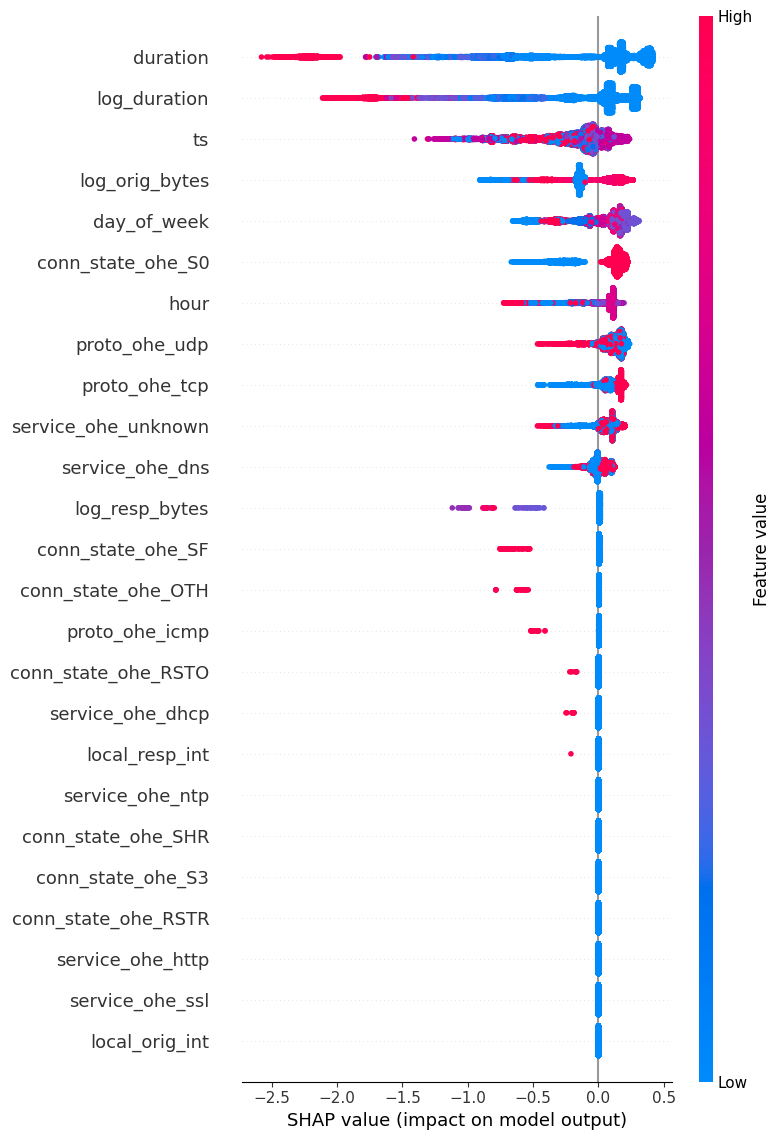

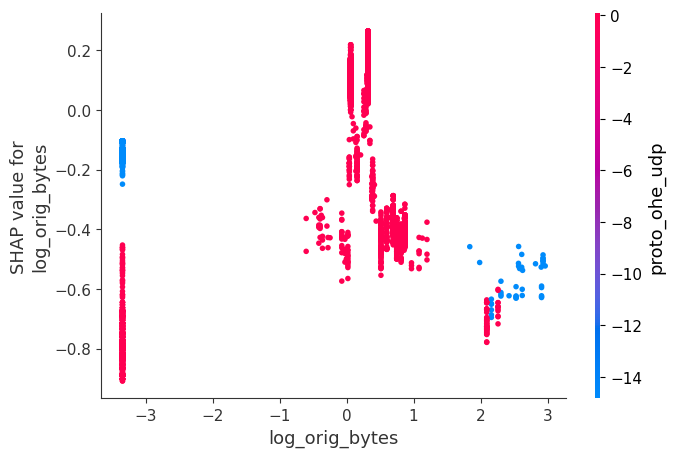

In [ ]:
from pyspark.ml.functions import vector_to_array
import pandas as pd, numpy as np, shap
from sklearn.ensemble import IsolationForest as SklearnIF

# 0) Sample & build X/y first
pdf = (scored
       .select(vector_to_array("scaled_features").alias("x"), "label_binary")
       .sample(False, 0.01, seed=RANDOM_STATE)
       .toPandas())
X = np.array(pdf["x"].tolist())
y = pdf["label_binary"].values
d = X.shape[1]

# 1) Recover names from metadata, sorted by idx (scaled_features preferred)
def extract_names(df, vec_col):
    meta = df.schema[vec_col].metadata
    names = []
    if "ml_attr" in meta and "attrs" in meta["ml_attr"]:
        pairs = []
        for key in ("numeric", "binary", "nominal"):
            for a in meta["ml_attr"]["attrs"].get(key, []):
                pairs.append((a["idx"], a["name"]))
        pairs.sort(key=lambda t: t[0])
        names = [n for _, n in pairs]
    return names

names = extract_names(scored, "scaled_features")
if len(names) != d:
    names = extract_names(scored, "features")  # same order post-scaling

# 2) Make lengths match 
if not names:
    names = [f"f{i}" for i in range(d)]
elif len(names) < d:
    names += [f"feat_{i}" for i in range(len(names), d)]
elif len(names) > d:
    names = names[:d]
assert len(names) == d

# 3) Use a DataFrame so SHAP reads column names
X_df = pd.DataFrame(X, columns=names)

# 4) Fit sklearn IF on the sample and explain
sk_if = SklearnIF(n_estimators=50, max_samples=256, max_features=0.5,
                  random_state=RANDOM_STATE, contamination=empirical_contam)
sk_if.fit(X_df)

explainer = shap.TreeExplainer(sk_if, model_output="raw")
shap_values = explainer.shap_values(X_df)

# 5) Plots (names will appear)
shap.summary_plot(shap_values, X_df, max_display=X_df.shape[1])

# Optional dependence plot (ensure the column exists)
if "log_orig_bytes" in X_df.columns:
    shap.dependence_plot("log_orig_bytes", shap_values, X_df)

In [15]:
# Unpersist df_model, which was used to train the the isolation forest model.
df_model.unpersist()

DataFrame[community_id: string, conn_state: string, duration: double, history: string, src_ip_zeek: string, src_port_zeek: bigint, dest_ip_zeek: string, dest_port_zeek: bigint, local_orig: boolean, local_resp: boolean, missed_bytes: bigint, orig_bytes: bigint, orig_ip_bytes: bigint, orig_pkts: bigint, proto: string, resp_bytes: bigint, resp_ip_bytes: bigint, resp_pkts: bigint, service: string, ts: double, uid: string, datetime: timestamp, vlan: bigint, label_tactic: string, label_technique: string, label_binary: int, label_cve: string, log_orig_bytes: double, log_resp_bytes: double, log_duration: double, hour: int, day_of_week: int, local_orig_int: int, local_resp_int: int]

In [16]:
# =====================================
# 8. Final Anomaly Score Metrics (Whole Dataset)
# =====================================
total_count = scored.count()
avg_score = scored.agg(F.avg("anomaly_score")).first()[0]
max_score = scored.agg(F.max("anomaly_score")).first()[0]
anomaly_rate = scored.filter(F.col("pred_iforest") == 1).count() / total_count

print("\n=== Final Anomaly Scores (Whole Dataset) ===")
print(f"Total records: {total_count:,}")
print(f"Average anomaly score: {avg_score:.6f}")
print(f"Maximum anomaly score: {max_score:.6f}")
print(f"Anomaly rate (pred_iforest=1): {anomaly_rate:.4f}")

scored.describe("anomaly_score").show()



=== Final Anomaly Scores (Whole Dataset) ===
Total records: 1,868,679
Average anomaly score: 0.573625
Maximum anomaly score: 0.828539
Anomaly rate (pred_iforest=1): 0.7515


[Stage 79:======================================================> (33 + 1) / 34]

+-------+-------------------+
|summary|      anomaly_score|
+-------+-------------------+
|  count|            1868679|
|   mean| 0.5736252745566436|
| stddev|0.14779173256936579|
|    min| 0.3768512914058611|
|    max|   0.82853930637329|
+-------+-------------------+



### <span style='color:#0070ff'>8. Threshold Tuning (PR curve)</span>

In [17]:
# Get time when cell run starts.
start_time = time.perf_counter()

pdf = scored.select("label_binary", "anomaly_score").sample(False, 0.2, seed=RANDOM_STATE).toPandas()

p, r, t = precision_recall_curve(pdf["label_binary"], pdf["anomaly_score"])
f1s = 2 * (p * r) / (p + r + 1e-8)
best_idx = f1s.argmax()
best_thr = t[best_idx]

print(f"Best threshold: {best_thr:.6f}, Best F1: {f1s[best_idx]:.4f}")

# Apply tuned threshold
scored = scored.withColumn("pred_custom", (F.col("anomaly_score") >= F.lit(float(best_thr))).cast("int"))

# Get time when cell run finished.
end_time = time.perf_counter()
print("Cell runtime in seconds:  " + str(end_time - start_time))

Best threshold: 0.674858, Best F1: 0.9917
Cell runtime in seconds:  2.800400490872562


### <span style='color:#0070ff'>9. Quick Metrics</span> 

In [18]:
# Get time when cell run starts.
start_time = time.perf_counter()

tp = scored.where("pred_custom=1 and label_binary=1").count()
fp = scored.where("pred_custom=1 and label_binary=0").count()
fn = scored.where("pred_custom=0 and label_binary=1").count()
tn = scored.where("pred_custom=0 and label_binary=0").count()

accuracy  = (tp + tn) / max(1, (tp + tn + fp + fn))
precision = tp / max(1, (tp + fp))
recall    = tp / max(1, (tp + fn))
f1        = 2 * precision * recall / (precision + recall + 1e-8)

print({"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1})

# AUC
try:
    auc = roc_auc_score(pdf["label_binary"].values, pdf["anomaly_score"].values)
    print({"auc": float(auc)})
except Exception as e:
    print("AUC error:", e)


# Get time when cell run finished.
end_time = time.perf_counter()
print("Cell runtime in seconds:  " + str(end_time - start_time))

{'accuracy': 0.9914672343404084, 'precision': 0.9832258689046204, 'recall': 0.9999967895656603, 'f1': 0.9915404134432534}
{'auc': 0.9889490756220527}
Cell runtime in seconds:  3.306649601086974


25/11/14 22:41:38 ERROR StandaloneSchedulerBackend: Application has been killed. Reason: Master removed our application: KILLED
25/11/14 22:41:39 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exiting due to error from cluster scheduler: Master removed our application: KILLED
	at org.apache.spark.errors.SparkCoreErrors$.clusterSchedulerError(SparkCoreErrors.scala:291)
	at org.apache.spark.scheduler.TaskSchedulerImpl.error(TaskSchedulerImpl.scala:981)
	at org.apache.spark.scheduler.cluster.StandaloneSchedulerBackend.dead(StandaloneSchedulerBackend.scala:165)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint.markDead(StandaloneAppClient.scala:263)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint$$anonfun$receive$1.applyOrElse(StandaloneAppClient.scala:170)
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:115)
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213)
	at org.apache.spark.rpc.netty.Inbox.proce

In [37]:
# Run this after queueing up all cells that you want execute.  This will stop your Spark Context and free up the
# cluster resources allocated to your job.  
sc.stop()